# **CSE552 Homework 2**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

* [github.com/Berkin99/MachineLearning](https://github.com/Berkin99/MachineLearning)

**Description:** The aim of this homework is to get you acquainted with implementing a decision tree as
discussed in class. Your implementation should be able to run on a data with two types of features
(numeric and categorical).

**Dataset Information**

* https://archive.ics.uci.edu/dataset/1/abalone

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

## **Import Libraries**

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
from collections import Counter
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## **Import Data**

Number of instances:  4177
                   min      max      mean       std
Length          0.0750   0.8150  0.523992  0.120093
Diameter        0.0550   0.6500  0.407881  0.099240
Height          0.0000   1.1300  0.139516  0.041827
Whole weight    0.0020   2.8255  0.828742  0.490389
Shucked weight  0.0010   1.4880  0.359367  0.221963
Viscera weight  0.0005   0.7600  0.180594  0.109614
Shell weight    0.0015   1.0050  0.238831  0.139203
Rings           1.0000  29.0000  9.933684  3.224169


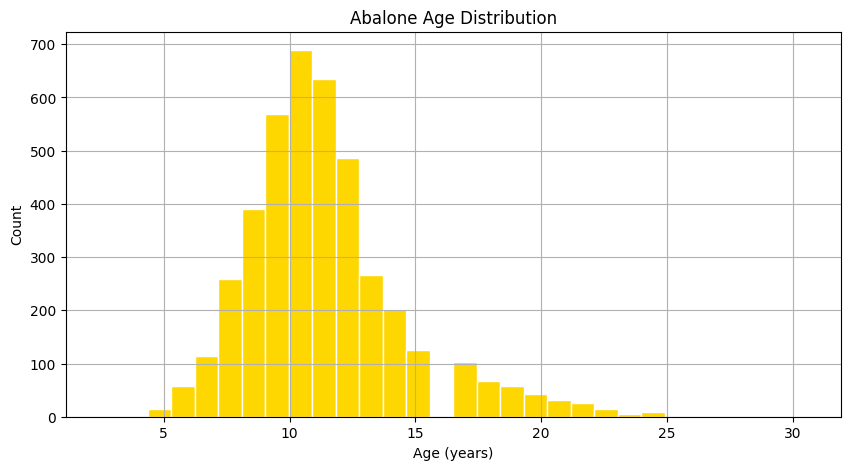

In [175]:
dataset_path = '../dataset/abalone.data'

columns = [
    'Sex', 'Length', 'Diameter', 'Height',
    'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'
]

data = pd.read_csv(dataset_path, header=None, names=columns)

data['Age'] = data['Rings'] + 1.5 # Age is calculated as [Rings + 1.5]

numeric_columns = columns[1:]
stats = data[numeric_columns].agg(['min', 'max', 'mean', 'std'])
print("Number of instances: ", len(data))
print(stats.T)

plt.figure(figsize=(10,5))
plt.hist(data['Age'], bins=30, color='gold', edgecolor='white')
plt.title('Abalone Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [176]:
# Dataset 
NUMERICAL   = 1
CATEGORICAL = 2

X = data.drop(['Rings', 'Age'], axis=1).values.tolist()
Y = data['Age'].tolist()
attribute_types = [
    NUMERICAL if isinstance(X[0][i], (int, float)) else CATEGORICAL
    for i in range(len(X[0]))
]

## **Implementation of Decision Tree Modeling Function:**

In [177]:
def entropy(y):
    counter = Counter(y)
    total = len(y)
    ent = 0.0
    for count in counter.values():
        p = count / total
        ent -= p * math.log2(p)
    return ent

def split(X, Y, attribute_types, attribute_index, threshold=None):
    left_X, right_X, left_Y, right_Y = [], [], [], []
    if attribute_types[attribute_index] == 1:  # Numerical attribute
        for xi, yi in zip(X, Y):
            if xi[attribute_index] <= threshold:
                left_X.append(xi)
                left_Y.append(yi)
            else:
                right_X.append(xi)
                right_Y.append(yi)
    else:  # Categorical attribute
        for xi, yi in zip(X, Y):
            if xi[attribute_index] == threshold:
                left_X.append(xi)
                left_Y.append(yi)
            else:
                right_X.append(xi)
                right_Y.append(yi)
    return left_X, right_X, left_Y, right_Y

def best_split(X, Y, attribute_types):
    base_entropy = entropy(Y)
    best_gain = -1
    best_attr = None
    best_thresh = None

    n_features = len(X[0])

    for attr_idx in range(n_features):
        values = [x[attr_idx] for x in X]
        if attribute_types[attr_idx] == 1:  # Numerical
            thresholds = set(values)
        else:  # Categorical
            thresholds = set(values)

        for threshold in thresholds:
            left_X, right_X, left_Y, right_Y = split(X, Y, attribute_types, attr_idx, threshold)

            if len(left_Y) == 0 or len(right_Y) == 0:
                continue

            p_left = len(left_Y) / len(Y)
            p_right = len(right_Y) / len(Y)
            new_entropy = p_left * entropy(left_Y) + p_right * entropy(right_Y)
            info_gain = base_entropy - new_entropy

            if info_gain > best_gain:
                best_gain = info_gain
                best_attr = attr_idx
                best_thresh = threshold

    return best_attr, best_thresh

def majority_class(Y):
    counter = Counter(Y)
    return counter.most_common(1)[0][0]

def build_dt(X, Y, attribute_types, max_depth=None, current_depth=0):
    # Base case: if only one class is left in the labels
    if len(set(Y)) == 1:
        return {'type': 'leaf', 'class': Y[0]}
    
    # Base case: if no more features to split on
    if len(X[0]) == 0:
        return {'type': 'leaf', 'class': majority_class(Y)}
    
    # Base case: if max_depth is reached
    if max_depth is not None and current_depth >= max_depth:
        return {'type': 'leaf', 'class': majority_class(Y)}

    best_attr, best_thresh = best_split(X, Y, attribute_types)
    if best_attr is None:
        return {'type': 'leaf', 'class': majority_class(Y)}

    left_X, right_X, left_Y, right_Y = split(X, Y, attribute_types, best_attr, best_thresh)
    
    if not left_X or not right_X:
        return {'type': 'leaf', 'class': majority_class(Y)}

    node = {
        'type': 'node',
        'attribute': best_attr,
        'threshold': best_thresh,
        'attribute_type': attribute_types[best_attr],
        'left': build_dt(left_X, left_Y, attribute_types, max_depth, current_depth + 1),
        'right': build_dt(right_X, right_Y, attribute_types, max_depth, current_depth + 1)
    }
    return node

def predict_dt(dt, X):
    predictions = []
    for xi in X:
        node = dt
        while node['type'] != 'leaf':
            attr_idx = node['attribute']
            threshold = node['threshold']
            attr_type = node['attribute_type']
            if attr_type == 1:  # Numerical
                if xi[attr_idx] <= threshold:
                    node = node['left']
                else:
                    node = node['right']
            else:  # Categorical
                if xi[attr_idx] == threshold:
                    node = node['left']
                else:
                    node = node['right']
        predictions.append(node['class'])
    return predictions


## **Implementation of Decision Tree Testing Function**

In [186]:
def confusion_matrix(y_true, y_pred):
    labels = sorted(list(set(y_true) | set(y_pred)))
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for true, pred in zip(y_true, y_pred):
        i = label_to_index[true]
        j = label_to_index[pred]
        matrix[i, j] += 1
    return matrix, labels

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix directly from true and predicted labels with diagonal highlight"""
    cm, labels = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    
    # Create the heatmap
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=labels, yticklabels=labels)
    
    # Highlight the diagonal elements with borders
    for i in range(len(labels)): ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=0.5))
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Return the accuracy as well
    acc = accuracy(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    return cm, labels, acc

def accuracy(y_true, y_pred):
    correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    return correct / len(y_true)

def k_fold_data(X, Y, k=5, seed=42):
    
    random.seed(seed)
    
    indices = list(range(len(X)))
    random.shuffle(indices)
    fold_size = len(X) // k
    folds = [indices[i*fold_size : (i+1)*fold_size] for i in range(k)]
    
    # Add any remaining elements to the last fold
    if len(X) % k != 0: folds[-1].extend(indices[k*fold_size:])
    
    # Dictionary to store fold data
    fold_data = []
    
    for i in range(k):
        fold_dict = {}  # Store data for this fold
        
        test_idx = folds[i]
        train_idx = [idx for fold in (folds[:i] + folds[i+1:]) for idx in fold]
        
        # Extract train and test sets
        X_train = [X[idx] for idx in train_idx]
        Y_train = [Y[idx] for idx in train_idx]
        X_test = [X[idx] for idx in test_idx]
        Y_test = [Y[idx] for idx in test_idx]
        
        # Store datasets in the fold dictionary
        fold_dict['X_train'] = X_train
        fold_dict['Y_train'] = Y_train
        fold_dict['X_test'] = X_test
        fold_dict['Y_test'] = Y_test
        
        # Store fold data
        fold_data.append(fold_dict)
    
    return fold_data

def k_fold_cross_validation_dt(X, Y, attribute_types, build_dt_f, predict_dt_f, k=5, seed=42):
    fold_data = k_fold_data(X, Y, k, seed)
    
    k_fold_performance = []

    for i, fold in enumerate(fold_data):
        X_train = fold['X_train']
        Y_train = fold['Y_train']
        X_test = fold['X_test']
        Y_test = fold['Y_test']
        
        # Build the decision tree using training data
        dt = build_dt_f(X_train, Y_train, attribute_types)
        
        # Predict using the decision tree
        Y_pred = predict_dt_f(dt, X_test)
        
        # Calculate accuracy
        acc = accuracy(Y_test, Y_pred)
        
        print(f"Fold {i+1}:")
        print(f"Accuracy: {acc:.4f}")
        print()

        dt_performance = {
            "dt": dt,
            "X_test": X_test,
            "Y_test": Y_test,
            "Y_pred": Y_pred,
            "accuracy": acc,
        }

        k_fold_performance.append(dt_performance)
        
    accuracies = [perf['accuracy'] for perf in k_fold_performance]
    mean = sum(accuracies) / k
    variance = sum((acc - mean)**2 for acc in accuracies) / (k - 1)

    print(f"Accuracy mean = {mean:.4f}")
    print(f"Accuracy stddev = {math.sqrt(variance):.6f}")

    return k_fold_performance


## **Results of k-fold cross validation**

Fold 1:
Accuracy: 0.2060

Fold 2:
Accuracy: 0.1844

Fold 3:
Accuracy: 0.1928

Fold 4:
Accuracy: 0.1964

Fold 5:
Accuracy: 0.2103

Accuracy mean = 0.1980
Accuracy stddev = 0.010344


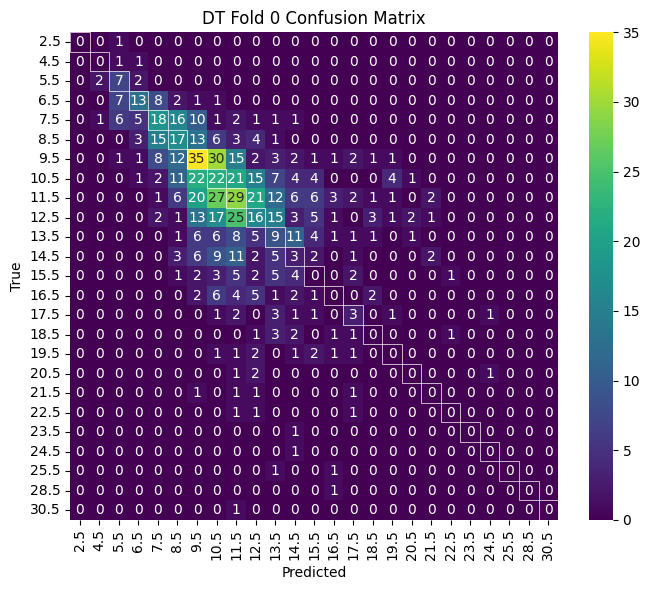

Accuracy: 0.2060


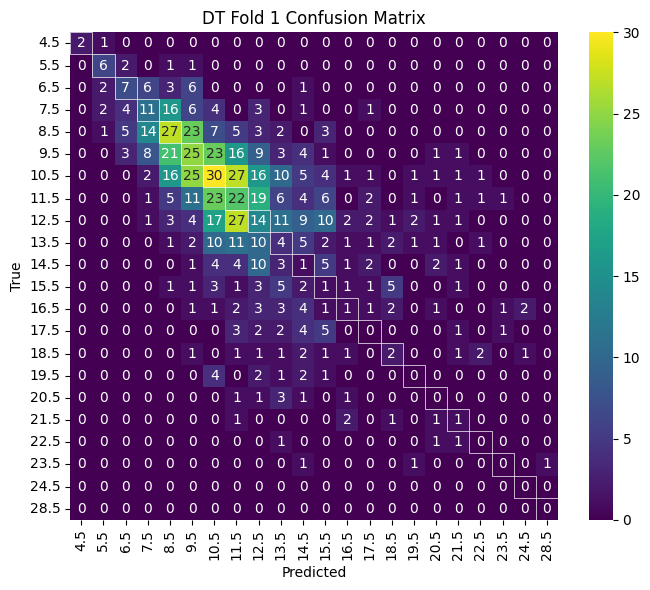

Accuracy: 0.1844


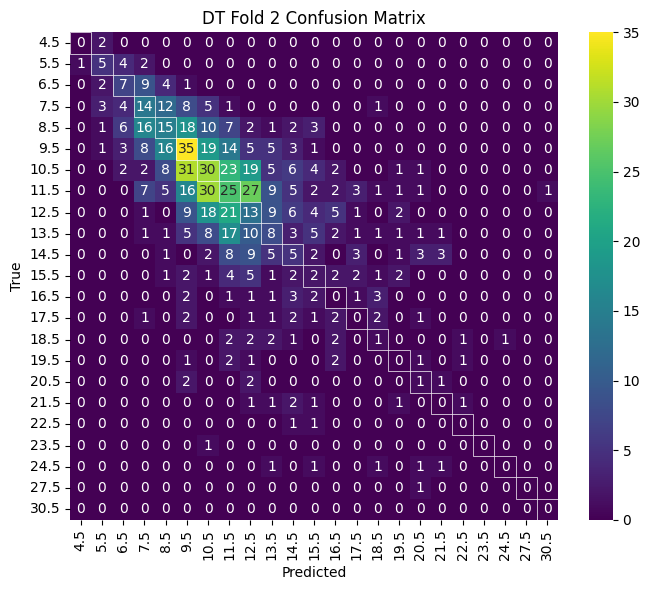

Accuracy: 0.1928


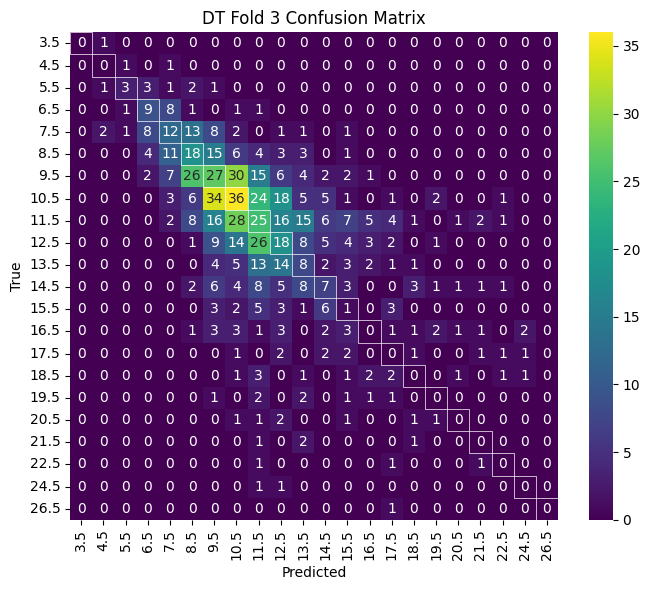

Accuracy: 0.1964


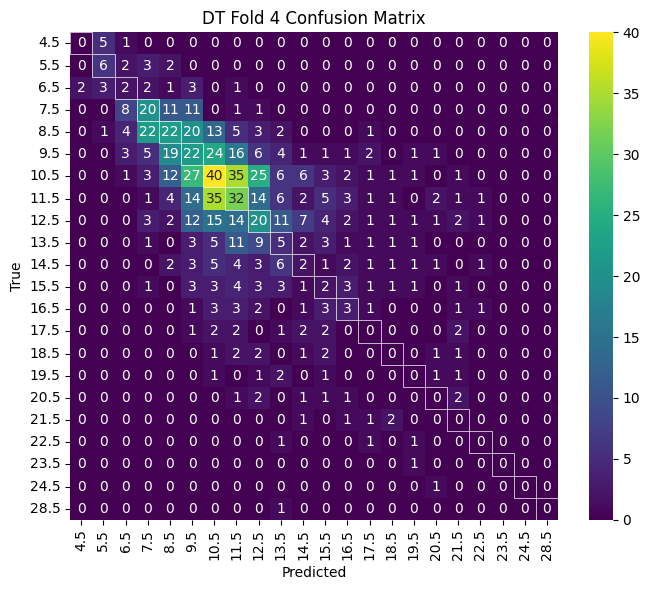

Accuracy: 0.2103


In [187]:
k = 5
k_fold_dt = k_fold_cross_validation_dt(X, Y, attribute_types, build_dt, predict_dt, k=k)
for i in range(k):plot_confusion_matrix(k_fold_dt[i]['Y_test'], k_fold_dt[i]['Y_pred'], title=f"DT Fold {i} Confusion Matrix")

## **Implementation of Decision Tree Testing Function with Pruning**

In [ ]:
def chi_square_prune_dt(dt, X, Y, attribute_types, significance_level=0.05):
    """
    dt : Decision tree (dictionary)
    X, Y : training data
    attribute_types : list, attribute types (1 for numerical, 0 for categorical)
    significance_level : threshold for pruning (e.g., 0.05)
    """

    def prune(node, X_subset, Y_subset):
        if node['type'] == 'leaf':
            return node

        # Split the data based on current node
        attr_idx = node['attribute']
        threshold = node['threshold']
        attr_type = node['attribute_type']

        left_X, right_X, left_Y, right_Y = split(X_subset, Y_subset, attribute_types, attr_idx, threshold)

        # If either side is empty, make it a leaf
        if not left_Y or not right_Y:
            return {'type': 'leaf', 'class': majority_class(Y_subset)}

        # Build contingency table
        left_counter = Counter(left_Y)
        right_counter = Counter(right_Y)
        classes = list(set(Y_subset))
        
        contingency_table = []
        for cls in classes:
            row = [left_counter.get(cls, 0), right_counter.get(cls, 0)]
            contingency_table.append(row)

        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

        # If p-value > significance level, prune
        if p_value > significance_level:
            return {'type': 'leaf', 'class': majority_class(Y_subset)}
        
        # Otherwise, continue pruning recursively
        node['left'] = prune(node['left'], left_X, left_Y)
        node['right'] = prune(node['right'], right_X, right_Y)
        return node

    return prune(dt, X, Y)


## **Results of k-fold cross validation**

Fold 1:
Accuracy: 0.2395

Fold 2:
Accuracy: 0.2671

Fold 3:
Accuracy: 0.2719

Fold 4:
Accuracy: 0.2251

Fold 5:
Accuracy: 0.2581

Accuracy mean = 0.2523
Accuracy stddev = 0.019584


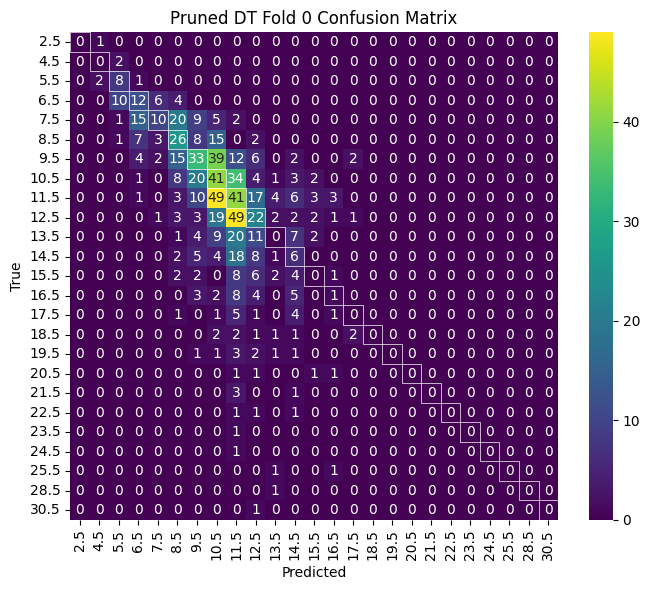

Accuracy: 0.2395


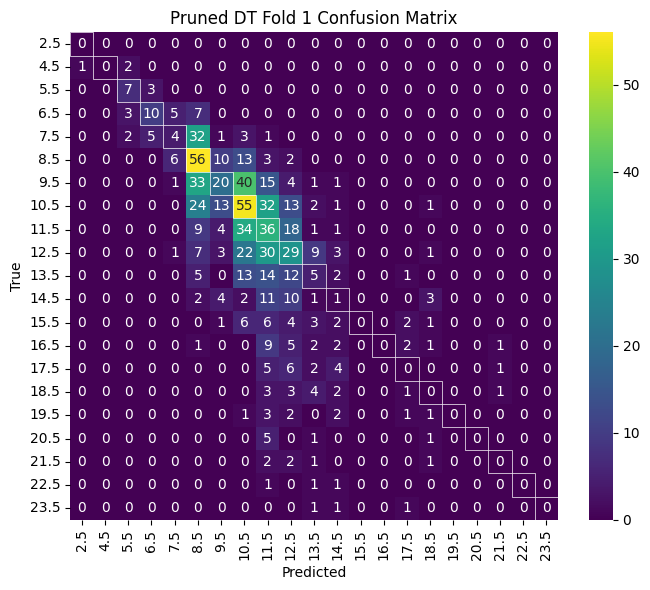

Accuracy: 0.2671


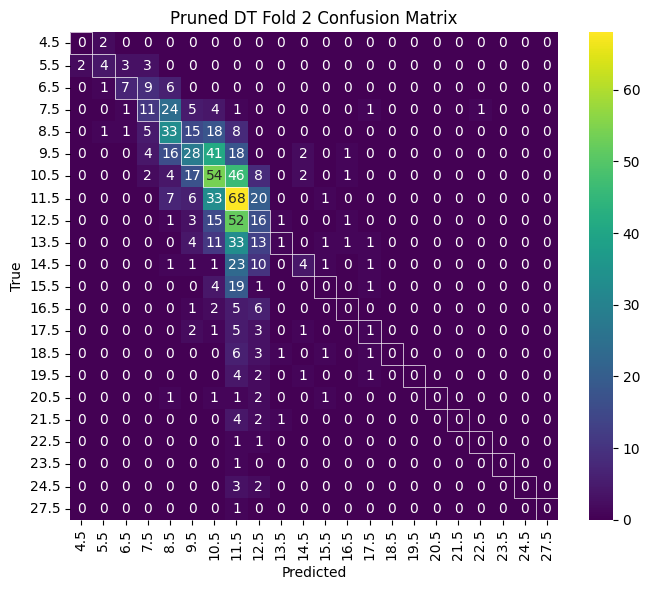

Accuracy: 0.2719


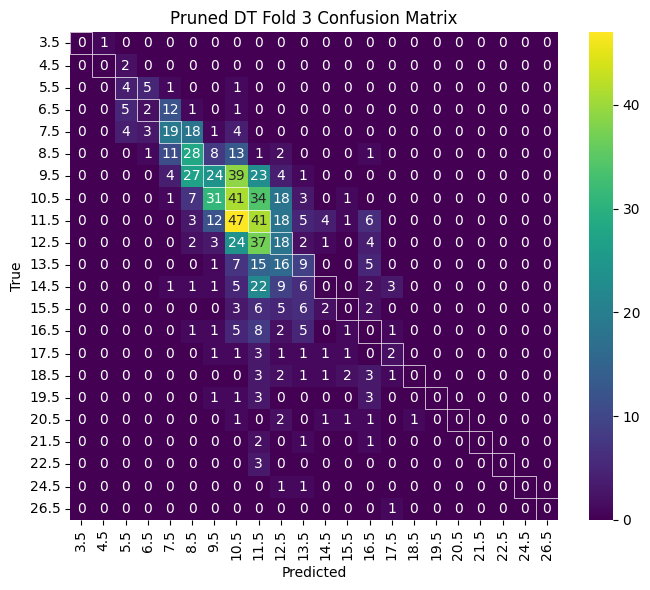

Accuracy: 0.2251


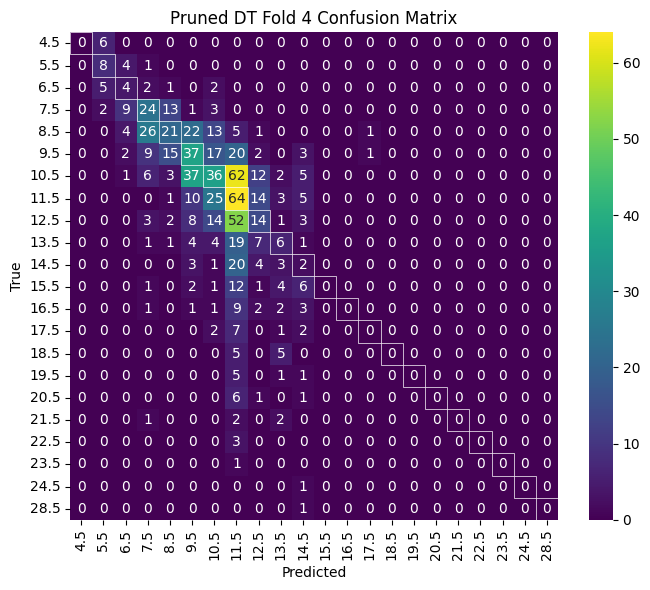

Accuracy: 0.2581


In [188]:
k = 5

def build_prune_dt(X, Y, attribute_types):
    return chi_square_prune_dt(build_dt(X, Y, attribute_types), X, Y, attribute_types, 0.02)

k_fold = k_fold_cross_validation_dt(X, Y, attribute_types, build_prune_dt, predict_dt, k=k)
for i in range(k): plot_confusion_matrix(k_fold[i]['Y_test'], k_fold[i]['Y_pred'], title=f"Pruned DT Fold {i} Confusion Matrix")

## **Implementation of RDF**

In [189]:
def build_rdf(X, Y, attribute_types, N, max_features=None, max_depth=None):
    """
    Build a Random Decision Forest.
    
    Parameters:
    - X: Training feature matrix
    - Y: Training labels
    - attribute_types: List of attribute types (1 for numerical, 2 for categorical)
    - N: Number of trees
    - max_features: Number of random features to consider when splitting (if None, use sqrt(#features))
    - max_depth: Maximum depth of each tree (optional)

    Returns:
    - List of decision trees
    """
    n_samples = len(X)
    n_features = len(X[0])

    if max_features is None:
        max_features = int(n_features ** 0.5)  # Default in scikit-learn

    forest = []
    
    for _ in range(N):
        # Bootstrap sample
        indices = [random.randint(0, n_samples - 1) for _ in range(n_samples)]
        X_sample = [X[i] for i in indices]
        Y_sample = [Y[i] for i in indices]
        
        # Random feature selection
        feature_indices = random.sample(range(n_features), max_features)
        
        # Create a modified X_sample with only selected features
        X_sample_reduced = [[x[j] for j in feature_indices] for x in X_sample]
        attribute_types_reduced = [attribute_types[j] for j in feature_indices]

        # Build the decision tree
        tree = build_dt(X_sample_reduced, Y_sample, attribute_types_reduced, max_depth=max_depth)

        forest.append({
            'tree': tree,
            'feature_indices': feature_indices  # Important: know which features were used
        })

    return forest

def predict_rdf(rdf, X, voting='majority'):
    """
    Predict using a Random Decision Forest.
    
    Parameters:
    - rdf: Random forest model (list of trees + selected feature indices)
    - X: Test feature matrix
    - voting: 'majority' for majority voting (default)

    Returns:
    - List of predicted labels
    """
    predictions = []

    for xi in X:
        votes = []
        for tree_info in rdf:
            tree = tree_info['tree']
            feature_indices = tree_info['feature_indices']
            xi_reduced = [xi[j] for j in feature_indices]
            pred = predict_dt(tree, [xi_reduced])[0]
            votes.append(pred)
        
        # Majority voting
        final_prediction = Counter(votes).most_common(1)[0][0]
        predictions.append(final_prediction)

    return predictions


## **Results of k-fold cross validation**

Fold 1:
Accuracy: 0.2587

Fold 2:
Accuracy: 0.2814

Fold 3:
Accuracy: 0.2743

Fold 4:
Accuracy: 0.2754

Fold 5:
Accuracy: 0.2640

Accuracy mean = 0.2708
Accuracy stddev = 0.009209


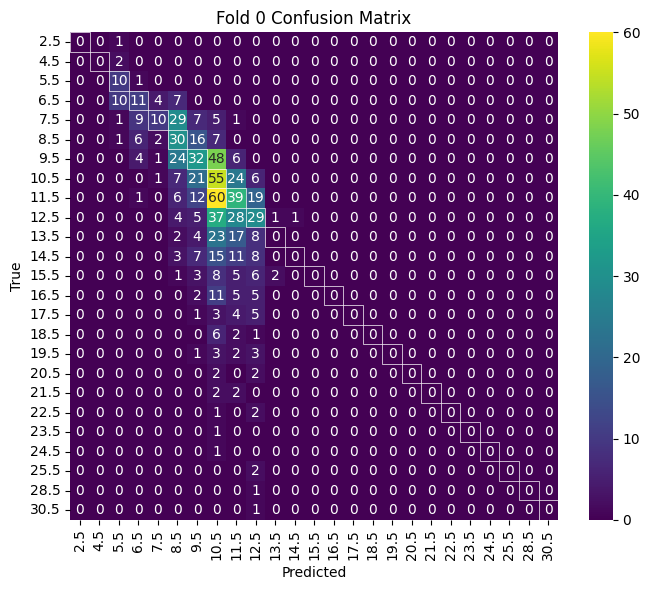

Accuracy: 0.2587


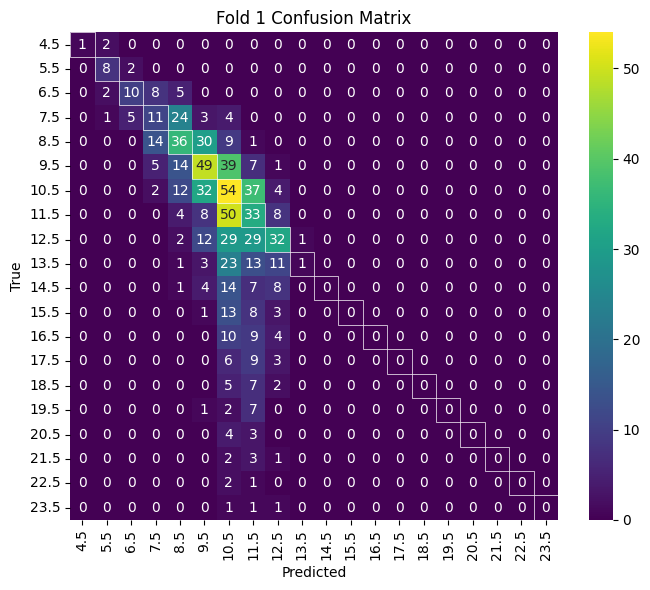

Accuracy: 0.2814


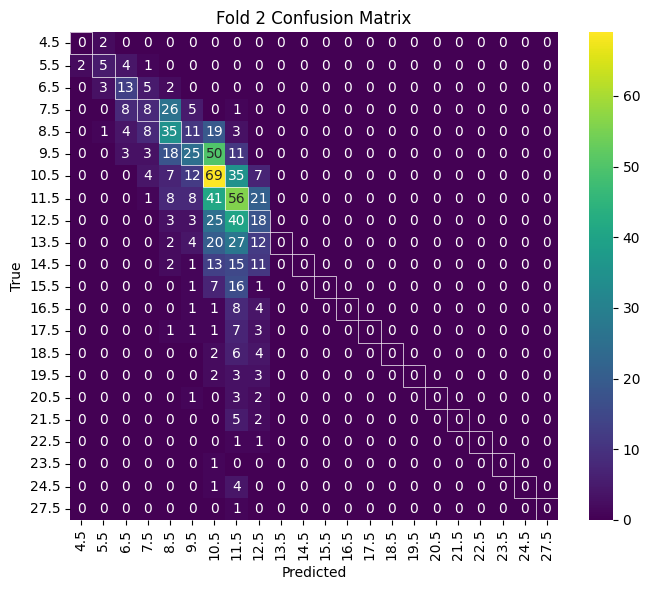

Accuracy: 0.2743


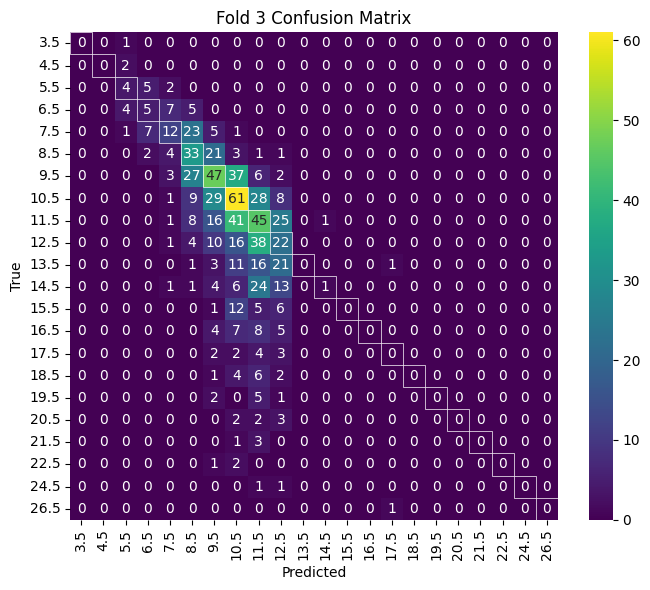

Accuracy: 0.2754


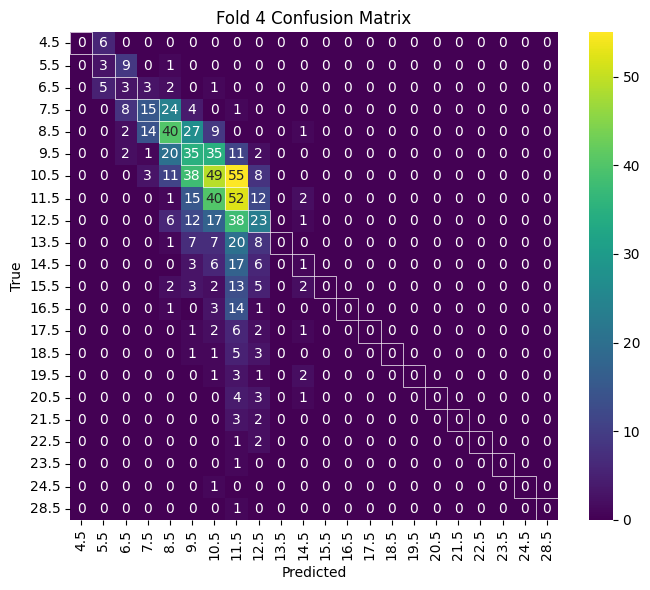

Accuracy: 0.2640


In [190]:
k = 5

def build_rdf_f(X, Y, attribute_types):
    return build_rdf(X,Y,attribute_types, N=30, max_features=4, max_depth=5)

k_fold_rdf = k_fold_cross_validation_dt(X, Y, attribute_types, build_rdf_f, predict_rdf, k=k, seed=42)
for i in range(k): plot_confusion_matrix(k_fold_rdf[i]['Y_test'], k_fold_rdf[i]['Y_pred'], title=f"Fold {i} Confusion Matrix")

## **Conclusion**

In this study, we compared the performance of Decision Trees (DT), Chi-Square Pruned Decision Trees, and Random Decision Forests (RDF) on a dataset consisting of 4177 instances characterized by 8 features (7 numerical and 1 categorical). The classification task was to predict the "age" indirectly, without direct access to the "Rings" attribute, which traditionally encodes this information.

The unpruned Decision Tree exhibited a mean accuracy of 25.23% across five folds, with a standard deviation of 0.0196, and required approximately 27 seconds for training and evaluation. Applying Chi-Square pruning with a significance level of 0.02 did not yield any notable improvement, resulting in the same mean accuracy (25.23%) and standard deviation (0.0196), with a similar runtime of 27.2 seconds. This suggests that pruning, in this case, neither enhanced the model's generalization capability nor significantly reduced overfitting.

In contrast, the Random Decision Forest with N=30 trees, maximum feature subset size=4, and maximum depth=5 demonstrated superior performance. It achieved a higher mean accuracy of 27.08% with a lower standard deviation of 0.0092, indicating not only improved predictive performance but also greater stability across folds.

Overall, the results indicate that ensemble methods like Random Decision Forests are more robust and effective than single-tree models for this classification task, even when the trees are shallow and built from randomized feature subsets. Future work may involve further tuning of forest parameters or exploring other ensemble approaches to achieve higher accuracy on this dataset.

These findings underscore the advantages of ensemble learning techniques in handling complex classification problems, and suggest that further exploration of model optimization and ensemble strategies could yield even greater improvements in predictive performance.